In [20]:
from fairseq import checkpoint_utils
import torch
hubert,_,_ = checkpoint_utils.load_model_ensemble_and_task(
    ["./hubert_base.pt"],
    suffix="",
)
hubert_model = hubert[0]
hubert_model = hubert_model
hubert_model.eval()

# Create a Adapter model
class HuberAdapter(torch.nn.Module):
    def __init__(self, model):
        super(HuberAdapter, self).__init__()
        self.model = model
    def forward(self,feats):
        # inputs = {
        #     "source": feats,
        #     "padding_mask": padding_mask,
        #     # "padding_mask": None,
        #     "output_layer": 12
        # }
        # return self.model.extract_features(**inputs)
        return self.model(
            source = feats,
            output_layer = 12,
            features_only = True,
            mask = False
        )['x']

# Loading presaved feats and padding mask
feats = torch.load("./feats.pt").float()
padding_mask = torch.load("./padding_mask.pt").float()

2025-02-21 09:38:30 | INFO | fairseq.tasks.hubert_pretraining | current directory is /root/hubert
2025-02-21 09:38:30 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2025-02-21 09:38:30 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0.1, 'final_dim': 256,

In [21]:
adapter = HuberAdapter(hubert_model.cuda())

In [22]:
output = adapter(feats)

In [23]:
output[0].shape

torch.Size([100, 768])

In [24]:
output[0]

tensor([[-0.1189, -0.0121, -0.1055,  ..., -0.0258,  0.1201, -0.0282],
        [-0.2384, -0.1191, -0.3019,  ..., -0.2731,  0.0824,  0.1035],
        [-0.1458, -0.0125, -0.2260,  ..., -0.2819, -0.0351,  0.0519],
        ...,
        [-0.0835,  0.2034, -0.3241,  ..., -0.0256,  0.3254,  0.0428],
        [-0.1327,  0.2221, -0.0961,  ...,  0.1379,  0.3199,  0.1590],
        [ 0.0546,  0.0265, -0.1795,  ..., -0.0234, -0.0333, -0.1389]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [25]:
output[0].dtype

torch.float32

In [9]:
!pip install onnx onnxruntime-gpu

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
  Using cached https://repo.huaweicloud.com/repository/pypi/packages/dd/5b/c4f95dbe652d14aeba9afaceb177e9ffc48ac3c03048dd3f872f26f07e34/onnx-1.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 9.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 33.1 MB/s eta 0:00:00


Before runnning exportation code,i;ve modified fairseq/models/wav2vec/utils.py with below code:
```python
def pad_to_multiple(x, multiple, dim=-1, value=0):
    # Inspired from https://github.com/lucidrains/local-attention/blob/master/local_attention/local_attention.py#L41
    if x is None:
        return None, 0
    tsz = x.size(dim)
    m = tsz / multiple
    remainder = math.ceil(m) * multiple - tsz
    m = float(m) # => If without this,will raise `Tensor object has no attribute is_integer()`
    if m.is_integer():
        return x, 0
    pad_offset = (0,) * (-1 - dim) * 2

    return F.pad(x, (*pad_offset, 0, remainder), value=value), remainder
```

In [26]:
torch.onnx.export(
    adapter.cuda(),
    (feats.cuda()),
    "hubert.onnx",
    input_names=["feats",],
    output_names=["logits",],
    dynamic_axes={
        "feats": {0: "seq"},
        # "padding_mask": {0: "seq"},
    },
    opset_version=14,
    do_constant_folding=True,
)

/root/miniconda3/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:16: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  remainder = math.ceil(m) * multiple - tsz
/root/miniconda3/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:17: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if float(m).is_integer():
/root/miniconda3/lib/python3.10/site-packages/fairseq/modules/multihead_attention.py:507: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so thi

In [27]:
# 读取ONNX
import onnxruntime as ort

model = ort.InferenceSession("./hubert.onnx",providers = ["CUDAExecutionProvider"])

model

2025-02-21 09:39:06.707089036 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn.so.9: cannot open shared object file: No such file or directory

2025-02-21 09:39:06.707113665 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


In [28]:
r = model.run(
    ["logits",],
    {
        "feats": feats.cpu().numpy(),
        # "padding_mask": padding_mask.cpu().numpy()
    }
)[0]

In [29]:
import numpy as np

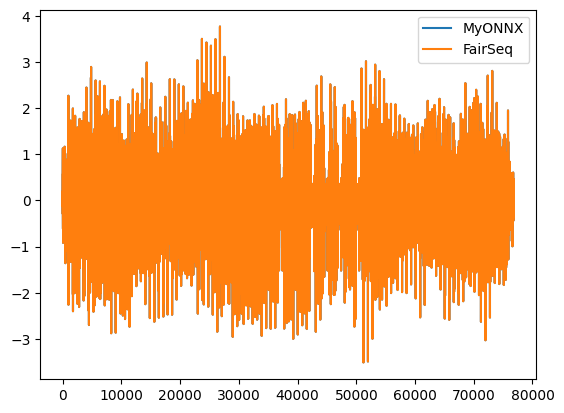

In [30]:
import matplotlib.pyplot as plt
plt.plot(np.array(r.flatten()),label="MyONNX")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="FairSeq")
plt.legend()
plt.savefig("./output.png",dpi=300)
plt.show()

In [33]:
# 量化
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

quantize_dynamic(
    "./hubert.onnx",
    "./hubert_quantized.onnx",
    weight_type = QuantType.QUInt8
)

2025-02-21 09:49:11 | WARNING | root | Please consider to run pre-processing before quantization. Refer to example: https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/image_classification/cpu/ReadMe.md 
2025-02-21 09:49:11 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/Unsqueeze_output_0" not specified
2025-02-21 09:49:11 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.0/conv_layers.0.3/Mul_1_output_0" not specified
2025-02-21 09:49:11 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.1/conv_layers.1.2/Mul_1_output_0" not specified
2025-02-21 09:49:11 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.2/conv_layers.2.2/Mul_1_output_0" not specified
2025-02-21 09:49:11 | INFO | root | Quantization parameters for tensor:"/model/feature_extractor/conv_layers.3/conv_layers.3.2/Mul_1_output_0" not specified
2025-0

In [34]:
model_q = ort.InferenceSession("./hubert_quantized.onnx",providers = ["CUDAExecutionProvider"])

2025-02-21 09:49:17.240154158 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn.so.9: cannot open shared object file: No such file or directory

2025-02-21 09:49:17.240173206 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


In [35]:
r_q = model_q.run(
    ["logits",],
    {
        "feats": feats.cpu().numpy(),
        # "padding_mask": padding_mask.cpu().numpy()
    }
)[0]

In [36]:
r_q

array([[[-0.15479021, -0.1321275 , -0.02256942, ..., -0.11149441,
          0.19733953, -0.02692895],
        [-0.04995577, -0.11857814, -0.38147512, ..., -0.0832834 ,
          0.14119375, -0.03433867],
        [ 0.11342429, -0.11735873, -0.26568496, ..., -0.19297394,
          0.17390321,  0.07635139],
        ...,
        [ 0.1296154 ,  0.14563492,  0.04868452, ..., -0.11369554,
          0.13559487,  0.01168949],
        [ 0.11623453,  0.13330682,  0.1890586 , ..., -0.06745703,
          0.1564116 , -0.16602533],
        [ 0.07371172, -0.01049889, -0.26068008, ..., -0.06769733,
         -0.0554914 , -0.19231898]]], dtype=float32)

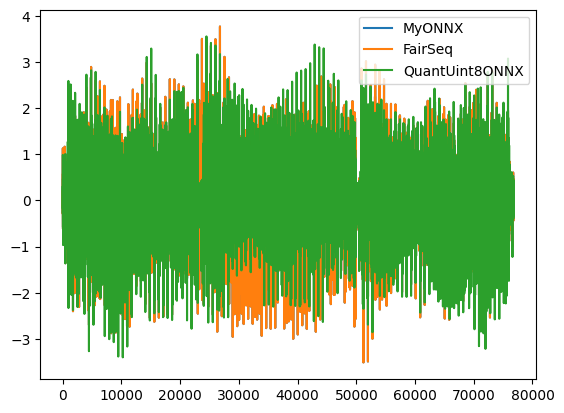

In [37]:
import matplotlib.pyplot as plt
plt.plot(np.array(r.flatten()),label="MyONNX")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="FairSeq")
plt.plot(np.array(r_q.flatten()),label="QuantUint8ONNX")
plt.legend()
plt.savefig("./output.png",dpi=300)
plt.show()

In [38]:
!pip install onnx-simplifier

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 47.4 MB/s eta 0:00:00


In [39]:
!onnxsim hubert_quantized.onnx hubert_quantized_simplified.onnx

Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                       ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add                   │ 172            │ 172              │
│ Cast                  │ 143            │ 93               │
│ Concat                │ 96             │ 72               │
│ Constant              │ 948            │ 348              │
│ ConvInteger           │ 8              │ 8                │
│ Div                   │ 70             │ 58               │
│ DynamicQuantizeLinear │ 57             │ 57               │
│ Erf                   │ 20             │ 20               │
│ Gather                │ 84             │ 60               │
│ InstanceNormalization │ 1              │ 1                │
│ MatMul                │ 24             │ 24               │
│ MatMulInteger         │ 73             │ 73               │
│ Mul                  

In [40]:
# 读取简化模型
model_q_s = ort.InferenceSession("./hubert_quantized_simplified.onnx",providers=["CPUExecutionProvider"])

model_q_s

In [41]:
r_q_s = model_q_s.run(
    ["logits",],
    {
        "feats": feats.cpu().numpy(),
        # "padding_mask": padding_mask.cpu().numpy()
    }
)[0]

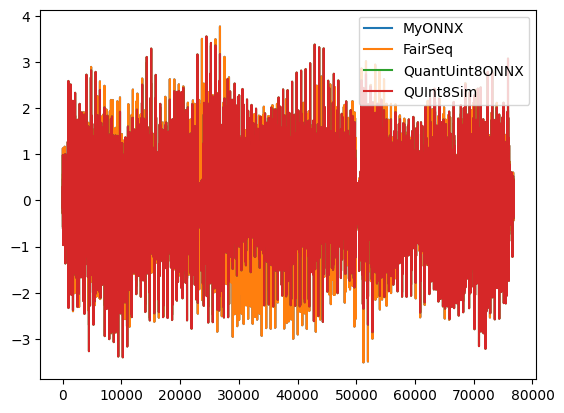

In [42]:
import matplotlib.pyplot as plt
plt.plot(np.array(r.flatten()),label="MyONNX")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="FairSeq")
plt.plot(np.array(r_q.flatten()),label="QuantUint8ONNX")
plt.plot(np.array(r_q_s.flatten()),label="QUInt8Sim")
plt.legend()
plt.savefig("./output.png",dpi=300)
plt.show()